# Mašinsko učenje - projekat 1
## Petra Milosavljević 1582
Korišćen dataset: https://archive.ics.uci.edu/dataset/419/autistic+spectrum+disorder+screening+data+for+children

### Biblioteke

In [153]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import arff
import math

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
from sklearn import tree
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.dummy import DummyClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn import metrics
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import cross_validate
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA

import warnings

pd.options.display.max_columns = None
warnings.filterwarnings("ignore", category=FutureWarning)

### Učitavanje dataseta i provera osnovnih informacija

In [120]:
arff_file = arff.loadarff('Autism-Child-Data.arff')
dataset = pd.DataFrame(arff_file[0])
dataset.head()

,A1_Score,A2_Score,A3_Score,A4_Score,A5_Score,A6_Score,A7_Score,A8_Score,A9_Score,A10_Score,age,gender,ethnicity,jundice,austim,contry_of_res,used_app_before,result,age_desc,relation,Class/ASD
0,b'1',b'1',b'0',b'0',b'1',b'1',b'0',b'1',b'0',b'0',6.00,b'm',b'Others',b'no',b'no',b'Jordan',b'no',5.00,b'4-11 years',b'Parent',b'NO'
1,b'1',b'1',b'0',b'0',b'1',b'1',b'0',b'1',b'0',b'0',6.00,b'm',b'Middle Eastern ',b'no',b'no',b'Jordan',b'no',5.00,b'4-11 years',b'Parent',b'NO'
2,b'1',b'1',b'0',b'0',b'0',b'1',b'1',b'1',b'0',b'0',6.00,b'm',b'?',b'no',b'no',b'Jordan',b'yes',5.00,b'4-11 years',b'?',b'NO'
3,b'0',b'1',b'0',b'0',b'1',b'1',b'0',b'0',b'0',b'1',5.00,b'f',b'?',b'yes',b'no',b'Jordan',b'no',4.00,b'4-11 years',b'?',b'NO'
4,b'1',b'1',b'1',b'1',b'1',b'1',b'1',b'1',b'1',b'1',5.00,b'm',b'Others',b'yes',b'no',b'United States',b'no',10.00,b'4-11 years',b'Parent',b'YES'


In [121]:
def decode_if_bytes(val):
    if isinstance(val, bytes):
        return val.decode('utf-8')
    return val

for col in dataset.columns:
    dataset[col] = dataset[col].apply(decode_if_bytes)

dataset.head()

,A1_Score,A2_Score,A3_Score,A4_Score,A5_Score,A6_Score,A7_Score,A8_Score,A9_Score,A10_Score,age,gender,ethnicity,jundice,austim,contry_of_res,used_app_before,result,age_desc,relation,Class/ASD
0,1,1,0,0,1,1,0,1,0,0,6.00,m,Others,no,no,Jordan,no,5.00,4-11 years,Parent,NO
1,1,1,0,0,1,1,0,1,0,0,6.00,m,Middle Eastern,no,no,Jordan,no,5.00,4-11 years,Parent,NO
2,1,1,0,0,0,1,1,1,0,0,6.00,m,?,no,no,Jordan,yes,5.00,4-11 years,?,NO
3,0,1,0,0,1,1,0,0,0,1,5.00,f,?,yes,no,Jordan,no,4.00,4-11 years,?,NO
4,1,1,1,1,1,1,1,1,1,1,5.00,m,Others,yes,no,United States,no,10.00,4-11 years,Parent,YES


In [122]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 292 entries, 0 to 291
Data columns (total 21 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   A1_Score         292 non-null    object 
 1   A2_Score         292 non-null    object 
 2   A3_Score         292 non-null    object 
 3   A4_Score         292 non-null    object 
 4   A5_Score         292 non-null    object 
 5   A6_Score         292 non-null    object 
 6   A7_Score         292 non-null    object 
 7   A8_Score         292 non-null    object 
 8   A9_Score         292 non-null    object 
 9   A10_Score        292 non-null    object 
 10  age              288 non-null    float64
 11  gender           292 non-null    object 
 12  ethnicity        292 non-null    object 
 13  jundice          292 non-null    object 
 14  austim           292 non-null    object 
 15  contry_of_res    292 non-null    object 
 16  used_app_before  292 non-null    object 
 17  result          

In [123]:
dataset = dataset.rename(columns={"Class/ASD": "class"})

In [124]:
numerical = dataset.select_dtypes(include='float64').columns.tolist()
objects = dataset.select_dtypes(include='object').columns.tolist()

In [125]:
dataset[numerical].describe()

,age,result
count,288.00,292.00
mean,6.35,6.24
std,2.37,2.28
min,4.00,0.00
25%,4.00,5.00
50%,6.00,6.00
75%,8.00,8.00
max,11.00,10.00


In [126]:
dataset[objects].describe()

,A1_Score,A2_Score,A3_Score,A4_Score,A5_Score,A6_Score,A7_Score,A8_Score,A9_Score,A10_Score,gender,ethnicity,jundice,austim,contry_of_res,used_app_before,age_desc,relation,class
count,292,292,292,292,292,292,292,292,292,292,292,292,292,292,292,292,292,292,292
unique,2,2,2,2,2,2,2,2,2,2,2,11,2,2,52,2,1,6,2
top,1,1,1,1,1,1,1,0,0,1,m,White-European,no,no,United Kingdom,no,4-11 years,Parent,NO
freq,185,156,217,161,217,208,177,147,148,212,208,108,212,243,49,281,292,214,151


U prethodnim koracima vidimo koliko feature-a imamo i koji su, kao i neke od osnovnih informacija.

Proveravamo i da li neki podaci nedostaju, kao i da li u datasetu ima duplikata.

In [127]:
missing_values = dataset.isnull().sum()
missing_values

A1_Score           0
A2_Score           0
A3_Score           0
A4_Score           0
A5_Score           0
A6_Score           0
A7_Score           0
A8_Score           0
A9_Score           0
A10_Score          0
age                4
gender             0
ethnicity          0
jundice            0
austim             0
contry_of_res      0
used_app_before    0
result             0
age_desc           0
relation           0
class              0
dtype: int64

Možemo videti da u koloni 'age' fali 4 podatka, u kasnijoj obradi će biti iskorišćen neki od metoda za obradu nedostajućih podataka.

In [128]:
dataset.duplicated().sum()

2

Vidimo da u datasetu postoji 2 duplikata, tako da možemo da ih uklonimo.

In [129]:
dataset = dataset.drop_duplicates(keep=False)
dataset.duplicated().sum()
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 288 entries, 0 to 291
Data columns (total 21 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   A1_Score         288 non-null    object 
 1   A2_Score         288 non-null    object 
 2   A3_Score         288 non-null    object 
 3   A4_Score         288 non-null    object 
 4   A5_Score         288 non-null    object 
 5   A6_Score         288 non-null    object 
 6   A7_Score         288 non-null    object 
 7   A8_Score         288 non-null    object 
 8   A9_Score         288 non-null    object 
 9   A10_Score        288 non-null    object 
 10  age              284 non-null    float64
 11  gender           288 non-null    object 
 12  ethnicity        288 non-null    object 
 13  jundice          288 non-null    object 
 14  austim           288 non-null    object 
 15  contry_of_res    288 non-null    object 
 16  used_app_before  288 non-null    object 
 17  result           288 

Možemo da prikažemo i koje sve vrednosti svaki od feature-a može da uzme.

In [130]:
for key in dataset.keys():
    print(key + ':\n', dataset[key].unique())

A1_Score:
 ['1' '0']
A2_Score:
 ['1' '0']
A3_Score:
 ['0' '1']
A4_Score:
 ['0' '1']
A5_Score:
 ['1' '0']
A6_Score:
 ['1' '0']
A7_Score:
 ['0' '1']
A8_Score:
 ['1' '0']
A9_Score:
 ['0' '1']
A10_Score:
 ['0' '1']
age:
 [ 6.  5.  4. 11. 10.  8.  7.  9. nan]
gender:
 ['m' 'f']
ethnicity:
 ['Others' 'Middle Eastern ' '?' 'White-European' 'Black' 'South Asian'
 'Asian' 'Pasifika' 'Hispanic' 'Turkish' 'Latino']
jundice:
 ['no' 'yes']
austim:
 ['no' 'yes']
contry_of_res:
 ['Jordan' 'United States' 'Egypt' 'United Kingdom' 'Bahrain' 'Austria'
 'Kuwait' 'United Arab Emirates' 'Europe' 'Malta' 'Bulgaria'
 'South Africa' 'India' 'Afghanistan' 'Georgia' 'New Zealand' 'Syria'
 'Iraq' 'Australia' 'Saudi Arabia' 'Armenia' 'Turkey' 'Pakistan' 'Canada'
 'Oman' 'Brazil' 'South Korea' 'Costa Rica' 'Sweden' 'Philippines'
 'Malaysia' 'Argentina' 'Japan' 'Bangladesh' 'Qatar' 'Ireland' 'Romania'
 'Netherlands' 'Lebanon' 'Germany' 'Latvia' 'Russia' 'Italy' 'China'
 'Nigeria' 'U.S. Outlying Islands' 'Nepal' 'Me

Vidimo da, pored kolone 'age', kolone 'ethnicity' i 'relation' takođe imaju podatke koji nedostaju i označeni su sa '?'.

### Vizuelizacija, analiza podataka i pretprocesiranje

Prvo, proveravamo kako je dataset balansiran.

class
NO     149
YES    139
Name: count, dtype: int64


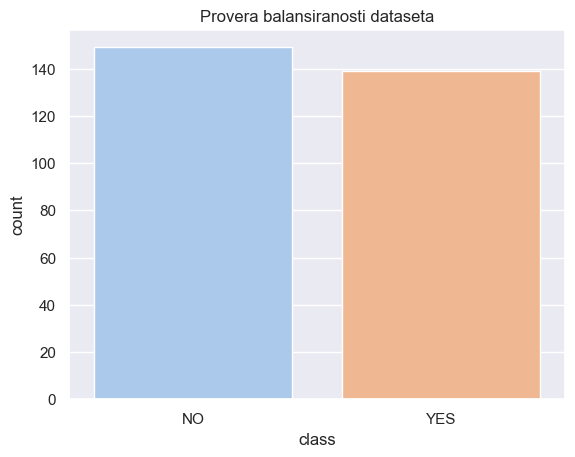

In [131]:
sns.set(font_scale=1)
sns.countplot(x='class', data=dataset, palette='pastel', hue='class')
plt.title('Provera balansiranosti dataseta')

print(dataset["class"].value_counts())

Iz dijagrama vidimo da je dataset dobro balansiran.

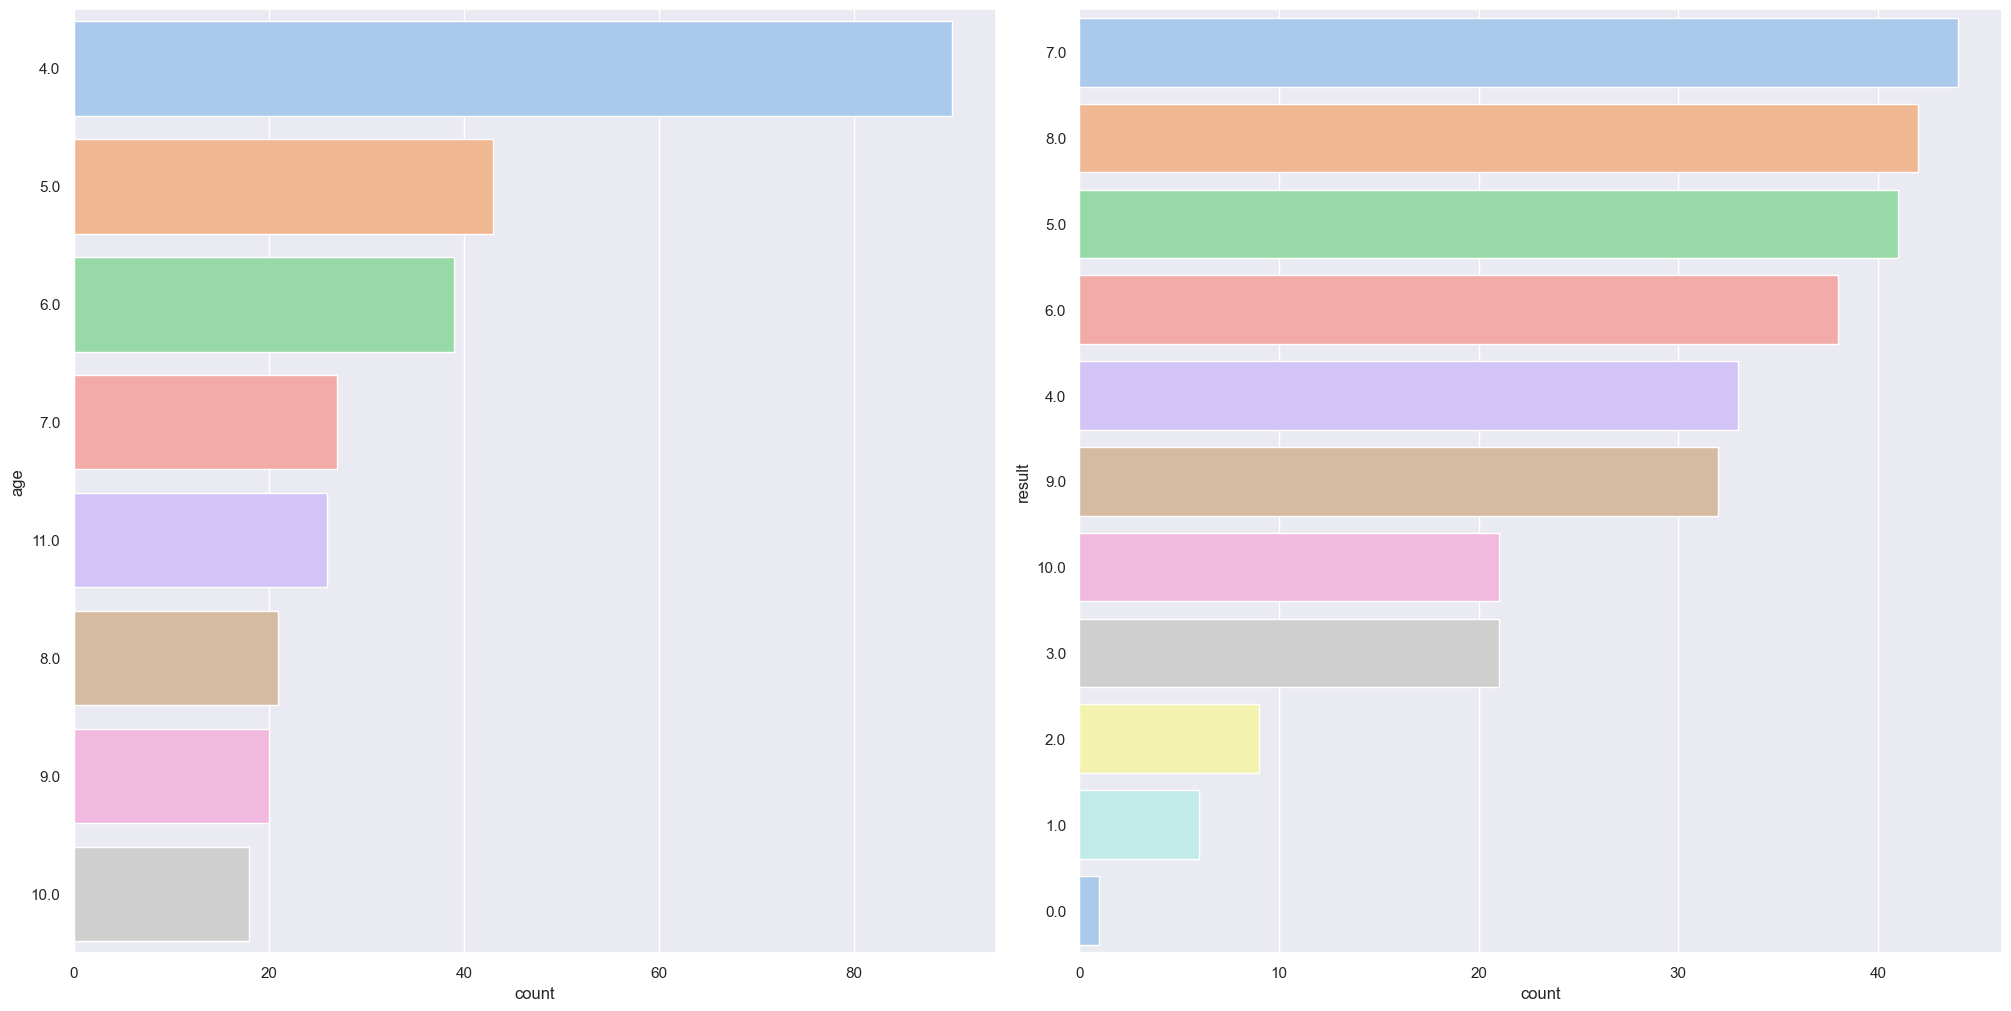

In [132]:
fig, axs = plt.subplots(1, 2, figsize=(20, 10), constrained_layout=True)

for i, f in enumerate(numerical):
    sns.countplot(y=f, data=dataset,
                  ax=axs[i % 2],
                  order=dataset[f].value_counts().index, palette='pastel')

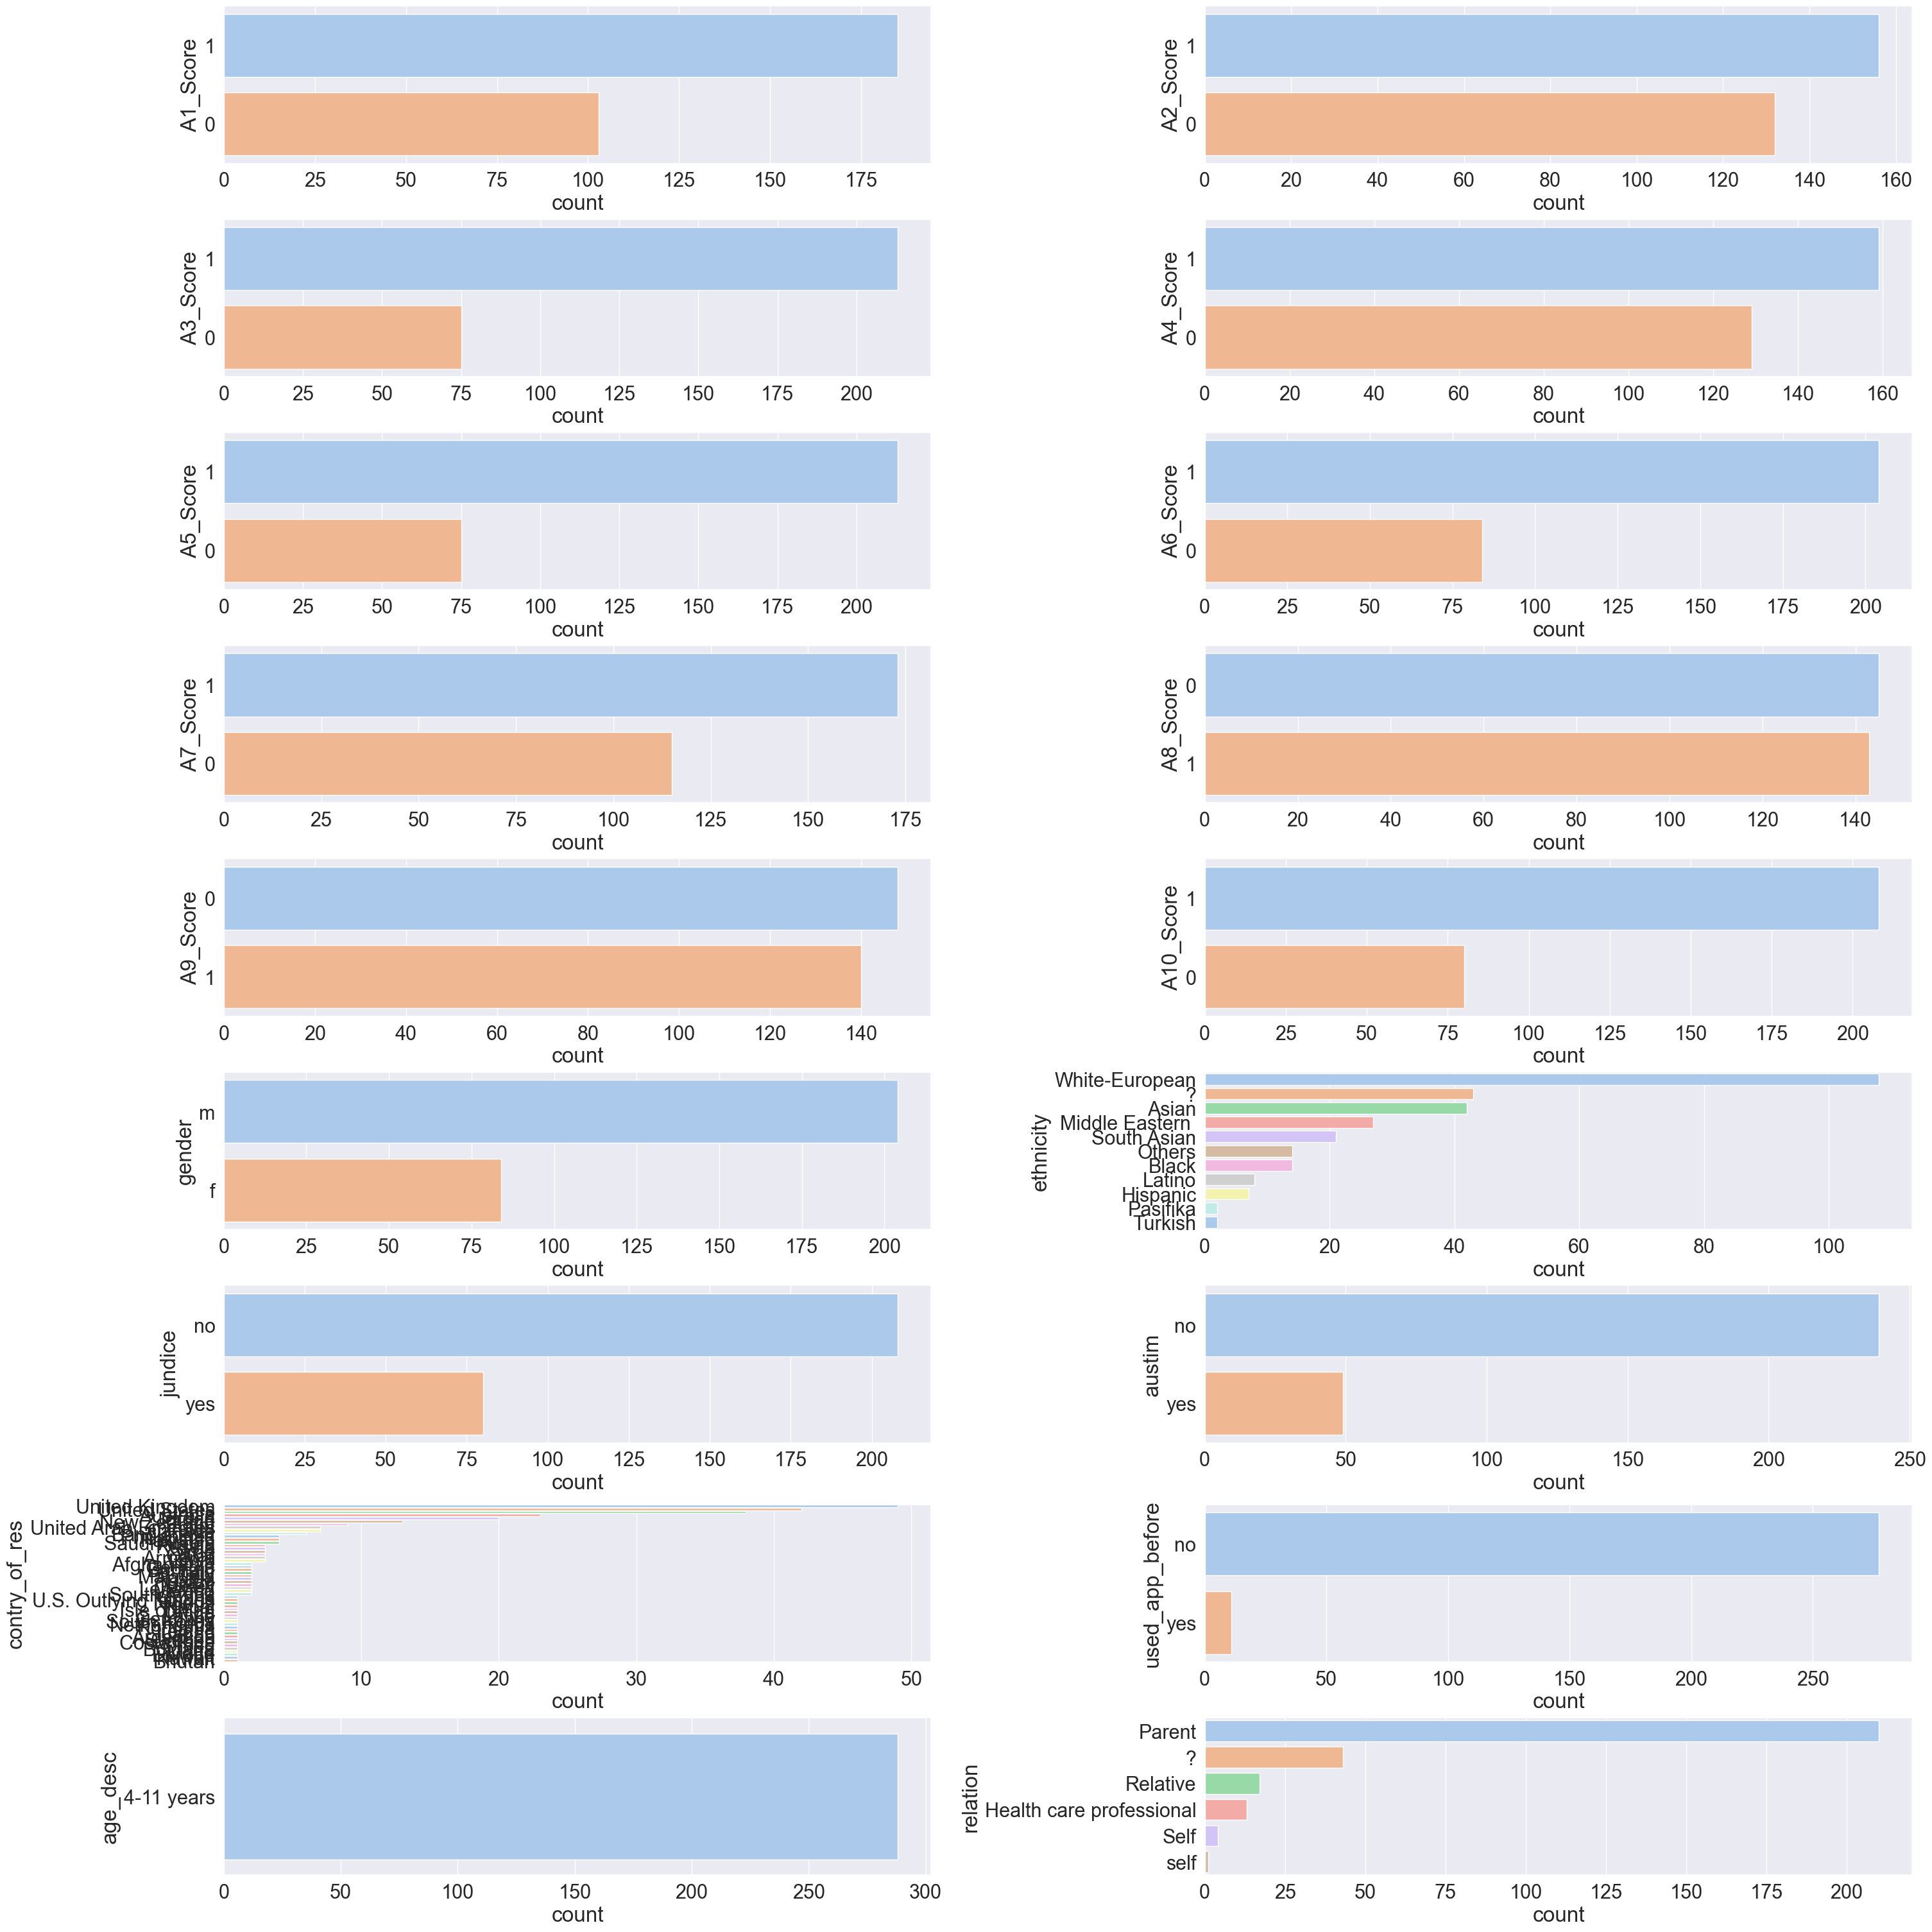

In [133]:
sns.set(font_scale=2)
fig, axs = plt.subplots(9, 2, figsize=(30, 30), constrained_layout=True)

for i, f in enumerate(objects[:-1]):
    sns.countplot(y=f, data=dataset,
                  ax=axs[i//2][i % 2],
                  order=dataset[f].value_counts().index, palette='pastel')

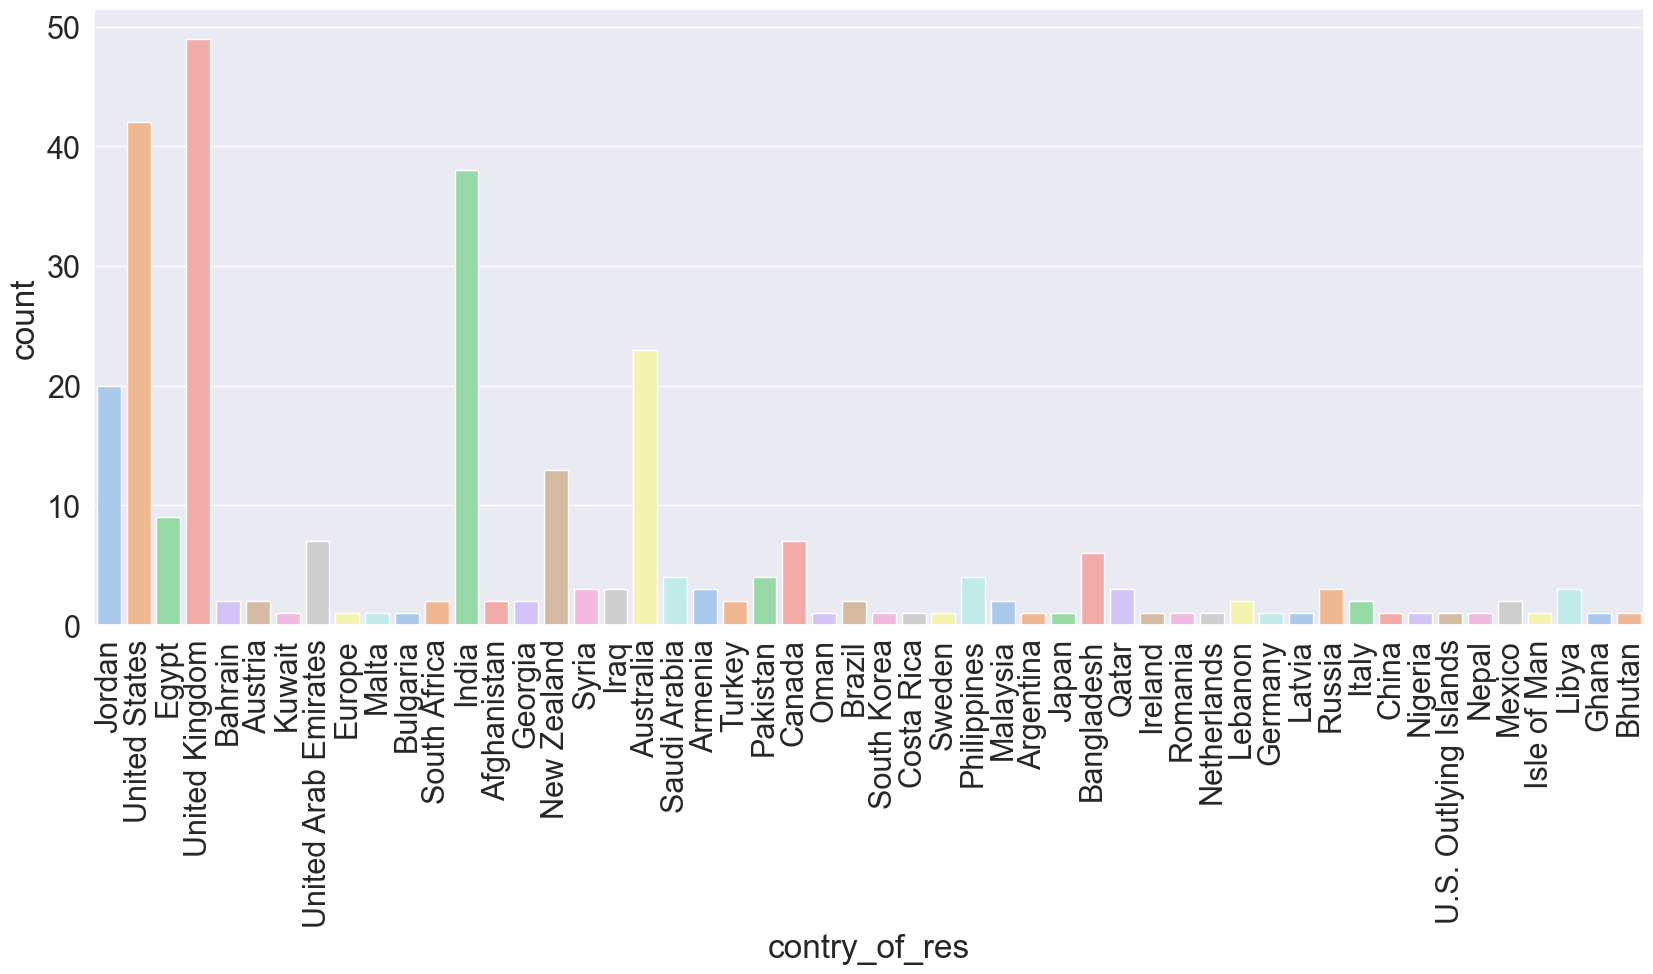

In [134]:
sns.set(font_scale=2)
fig, ax = plt.subplots()
fig.set_size_inches(20, 8)
sns.countplot(x='contry_of_res', data=dataset, orient='v', palette="pastel")
ax.tick_params(axis='x', rotation=90)

Neke od vrednosti možemo grupisati.

In [135]:
eu = ['Austria', 'Europe', 'Malta', 'Bulgaria', 'Sweden', 'Romania', 'Netherlands', 'Germany', 'Latvia', 'Italy', 'Georgia', 'Armenia', 'Russia']
middle_east = ['Jordan', 'Bahrain', 'Kuwait', 'United Arab Emirates', 'Turkey', 'Oman', 'Egypt', 'Qatar', 'Lebanon', 'Syria', 'Iraq', 'Saudi Arabia']
uk = ['United Kingdom', 'Ireland', 'Isle of Man']
africa = ['South Africa', 'Nigeria', 'Ghana', 'Libya']
asia = ['India', 'Afghanistan', 'Pakistan', 'Philippines', 'Malaysia', 'Bangladesh', 'Japan', 'China', 'Bhutan', 'Nepal', 'South Korea']
north_america = ['United States', 'U.S. Outlying Islands', 'Canada', 'Mexico', 'Costa Rica']
south_america = ['Brazil', 'Argentina']
oceania = ['New Zealand', 'Australia']

dataset['contry_of_res'] = dataset['contry_of_res'].replace(eu, 'EU')
dataset['contry_of_res'] = dataset['contry_of_res'].replace(middle_east, 'Middle East')
dataset['contry_of_res'] = dataset['contry_of_res'].replace(uk, 'UK')
dataset['contry_of_res'] = dataset['contry_of_res'].replace(africa, 'Africa')
dataset['contry_of_res'] = dataset['contry_of_res'].replace(asia, 'Asia')
dataset['contry_of_res'] = dataset['contry_of_res'].replace(north_america, 'North America')
dataset['contry_of_res'] = dataset['contry_of_res'].replace(south_america, 'South America')

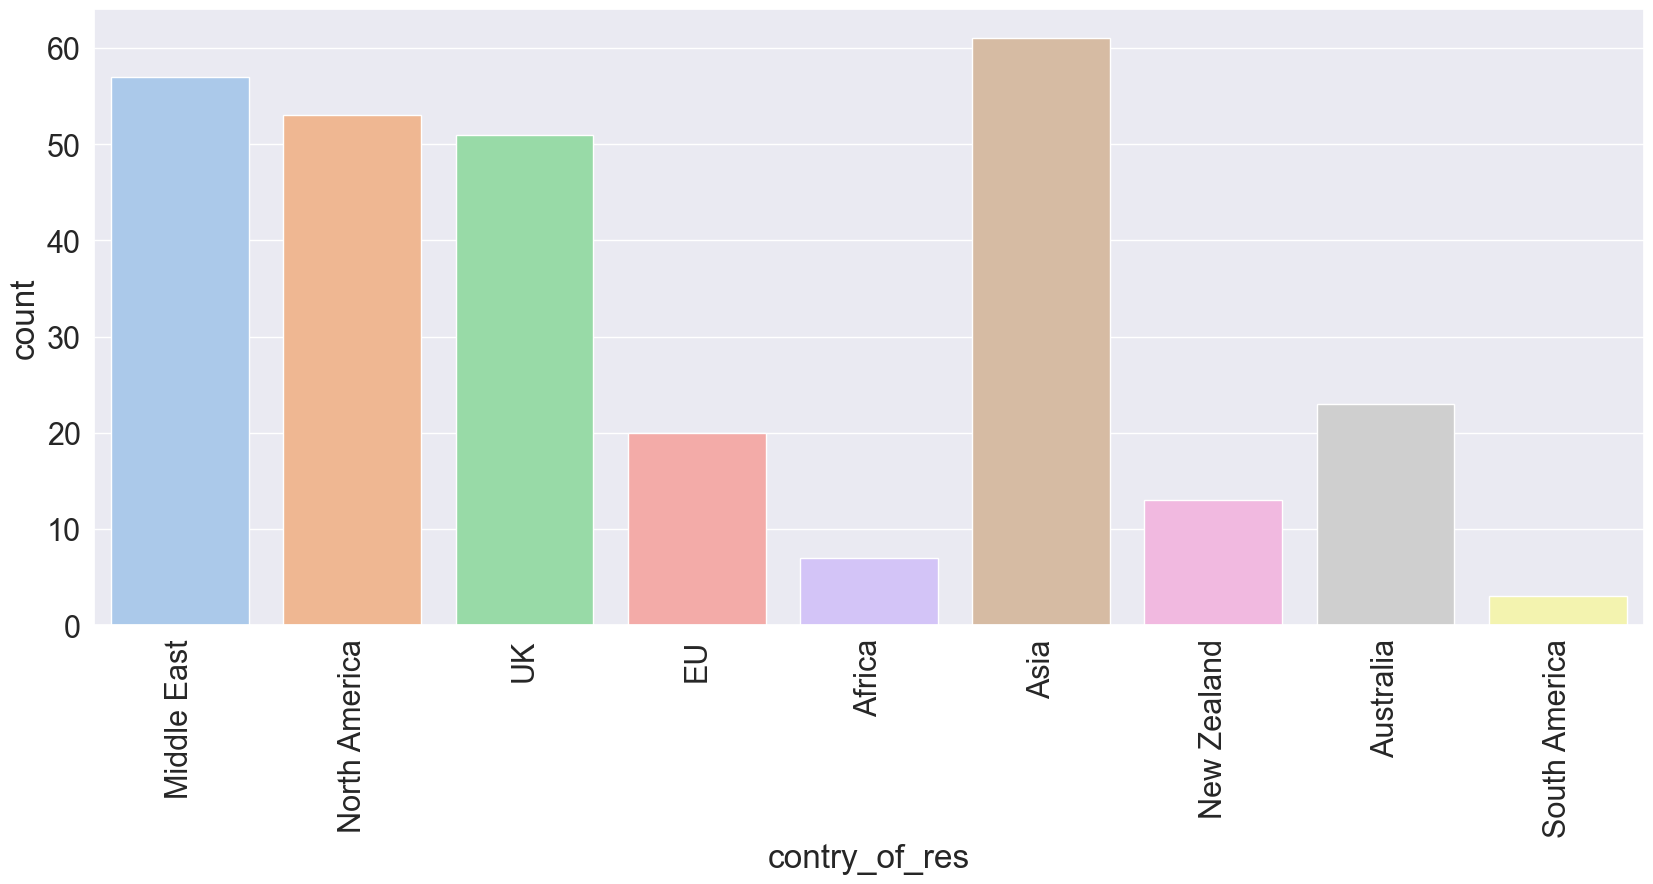

In [136]:
sns.set(font_scale=2)
fig, ax = plt.subplots()
fig.set_size_inches(20, 8)
sns.countplot(x='contry_of_res', data=dataset, orient='v', palette="pastel")
ax.tick_params(axis='x', rotation=90)

<Axes: xlabel='age_desc', ylabel='count'>

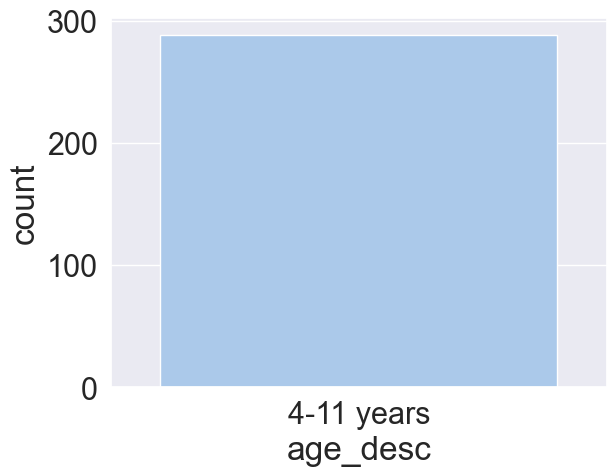

In [137]:
fig, ax = plt.subplots()
sns.set(font_scale=2)
sns.countplot(x='age_desc', data=dataset, orient='v', palette="pastel")

Feature 'age_desc' možemo ukloniti jer ne daje nikakve informacije.

In [138]:
dataset = dataset.drop(['age_desc'], axis=1)
dataset.head()

,A1_Score,A2_Score,A3_Score,A4_Score,A5_Score,A6_Score,A7_Score,A8_Score,A9_Score,A10_Score,age,gender,ethnicity,jundice,austim,contry_of_res,used_app_before,result,relation,class
0,1,1,0,0,1,1,0,1,0,0,6.00,m,Others,no,no,Middle East,no,5.00,Parent,NO
1,1,1,0,0,1,1,0,1,0,0,6.00,m,Middle Eastern,no,no,Middle East,no,5.00,Parent,NO
2,1,1,0,0,0,1,1,1,0,0,6.00,m,?,no,no,Middle East,yes,5.00,?,NO
3,0,1,0,0,1,1,0,0,0,1,5.00,f,?,yes,no,Middle East,no,4.00,?,NO
4,1,1,1,1,1,1,1,1,1,1,5.00,m,Others,yes,no,North America,no,10.00,Parent,YES


U koloni 'relation' imamo vrednosti 'self' i 'Self' koje predstavljaju istu stvar, tako da ćemo ih spojiti.

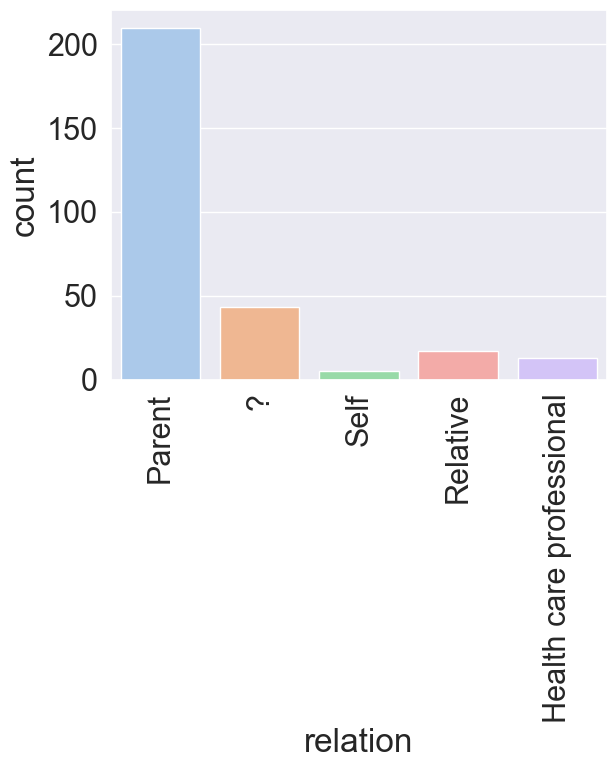

In [139]:
dataset['relation'].replace('self', 'Self', inplace=True)

fig, ax = plt.subplots()
sns.countplot(x='relation', data=dataset, palette="pastel")
ax.tick_params(axis='x', rotation=90)

Što se tiče nedostajućih vrednosti, kolona 'age' ima mali broj (4) nedostajućih vrednosti, tako da bi moglo da se uradi i izbacivanje tih instanci. Međutim, dataset ima mali broj primeraka (280), tako da ćemo za tu kolonu uraditi jednostavnu zamenu nedostajuće vrednosti sa medijanom kolone.

In [140]:
dataset['age'].fillna(dataset['age'].median(), inplace=True)
dataset.isnull().sum()

A1_Score           0
A2_Score           0
A3_Score           0
A4_Score           0
A5_Score           0
A6_Score           0
A7_Score           0
A8_Score           0
A9_Score           0
A10_Score          0
age                0
gender             0
ethnicity          0
jundice            0
austim             0
contry_of_res      0
used_app_before    0
result             0
relation           0
class              0
dtype: int64

Ostale kolone sa nedostajućim podacima su 'ethnicity' i 'relation', obe imaju kategoričke vrednosti. Prvo se koristi Label Encoder nad kategorickim kolonama, da bi mogao da se upotrebi Imputer.


In [141]:
label_encoder_ethnicity = LabelEncoder()
label_encoder_relation = LabelEncoder()

dataset['ethnicity'] = dataset['ethnicity'].apply(lambda x: np.nan if x == '?' else x)
dataset['relation'] = dataset['relation'].apply(lambda x: np.nan if x == '?' else x)

dataset['ethnicity'] = pd.Series(label_encoder_ethnicity.fit_transform(dataset['ethnicity'].dropna()), index=dataset['ethnicity'].dropna().index)
dataset['relation'] = pd.Series(label_encoder_relation.fit_transform(dataset['relation'].dropna()), index=dataset['relation'].dropna().index)

dataset['ethnicity'] = dataset['ethnicity'].reindex(dataset.index, fill_value=np.nan)
dataset['relation'] = dataset['relation'].reindex(dataset.index, fill_value=np.nan)

iterative_imputer = IterativeImputer(max_iter=10, random_state=0, initial_strategy='most_frequent')

dataset[['ethnicity', 'relation']] = iterative_imputer.fit_transform(dataset[['ethnicity', 'relation']])

dataset['ethnicity'] = label_encoder_ethnicity.inverse_transform(dataset['ethnicity'].astype(int))
dataset['relation'] = label_encoder_relation.inverse_transform(dataset['relation'].astype(int))

<class 'pandas.core.frame.DataFrame'>
Index: 288 entries, 0 to 291
Data columns (total 20 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   A1_Score         288 non-null    object 
 1   A2_Score         288 non-null    object 
 2   A3_Score         288 non-null    object 
 3   A4_Score         288 non-null    object 
 4   A5_Score         288 non-null    object 
 5   A6_Score         288 non-null    object 
 6   A7_Score         288 non-null    object 
 7   A8_Score         288 non-null    object 
 8   A9_Score         288 non-null    object 
 9   A10_Score        288 non-null    object 
 10  age              288 non-null    float64
 11  gender           288 non-null    object 
 12  ethnicity        288 non-null    object 
 13  jundice          288 non-null    object 
 14  austim           288 non-null    object 
 15  contry_of_res    288 non-null    object 
 16  used_app_before  288 non-null    object 
 17  result           288 

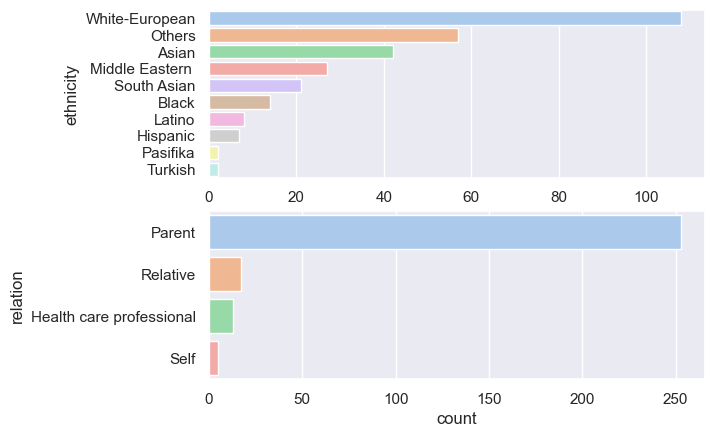

In [142]:
sns.set(font_scale=1)
fig, axs = plt.subplots(2, 1)
sns.countplot(y='ethnicity', data=dataset, ax=axs[0], order=dataset['ethnicity'].value_counts().index, palette='pastel')
sns.countplot(y='relation', data=dataset, ax=axs[1], order=dataset['relation'].value_counts().index, palette='pastel')

dataset.info()

### Kodiranje kategoričkih vrednosti

In [143]:
dataset['gender'] = dataset['gender'].map({'m': 1, 'f': 0})
dataset['jundice'] = dataset['jundice'].map({'yes': 1, 'no': 0})
dataset['austim'] = dataset['austim'].map({'yes': 1, 'no': 0})
dataset['used_app_before'] = dataset['used_app_before'].map({'yes': 1, 'no': 0})
dataset['class'] = dataset['class'].map({'YES': 1, 'NO': 0})

dataset.head()

,A1_Score,A2_Score,A3_Score,A4_Score,A5_Score,A6_Score,A7_Score,A8_Score,A9_Score,A10_Score,age,gender,ethnicity,jundice,austim,contry_of_res,used_app_before,result,relation,class
0,1,1,0,0,1,1,0,1,0,0,6.00,1,Others,0,0,Middle East,0,5.00,Parent,0
1,1,1,0,0,1,1,0,1,0,0,6.00,1,Middle Eastern,0,0,Middle East,0,5.00,Parent,0
2,1,1,0,0,0,1,1,1,0,0,6.00,1,Others,0,0,Middle East,1,5.00,Parent,0
3,0,1,0,0,1,1,0,0,0,1,5.00,0,Others,1,0,Middle East,0,4.00,Parent,0
4,1,1,1,1,1,1,1,1,1,1,5.00,1,Others,1,0,North America,0,10.00,Parent,1


In [144]:
label_encoder = LabelEncoder()
# label_encoder_relation = LabelEncoder()
# label_encoder_contry_of_res = LabelEncoder()

dataset['ethnicity'] = label_encoder.fit_transform(dataset['ethnicity'])
dataset['relation'] = label_encoder.fit_transform(dataset['relation'])
dataset['contry_of_res'] = label_encoder.fit_transform(dataset['contry_of_res'])

dataset = dataset.astype('float64')
dataset.head()

,A1_Score,A2_Score,A3_Score,A4_Score,A5_Score,A6_Score,A7_Score,A8_Score,A9_Score,A10_Score,age,gender,ethnicity,jundice,austim,contry_of_res,used_app_before,result,relation,class
0,1.00,1.00,0.00,0.00,1.00,1.00,0.00,1.00,0.00,0.00,6.00,1.00,5.00,0.00,0.00,4.00,0.00,5.00,1.00,0.00
1,1.00,1.00,0.00,0.00,1.00,1.00,0.00,1.00,0.00,0.00,6.00,1.00,4.00,0.00,0.00,4.00,0.00,5.00,1.00,0.00
2,1.00,1.00,0.00,0.00,0.00,1.00,1.00,1.00,0.00,0.00,6.00,1.00,5.00,0.00,0.00,4.00,1.00,5.00,1.00,0.00
3,0.00,1.00,0.00,0.00,1.00,1.00,0.00,0.00,0.00,1.00,5.00,0.00,5.00,1.00,0.00,4.00,0.00,4.00,1.00,0.00
4,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,5.00,1.00,5.00,1.00,0.00,6.00,0.00,10.00,1.00,1.00


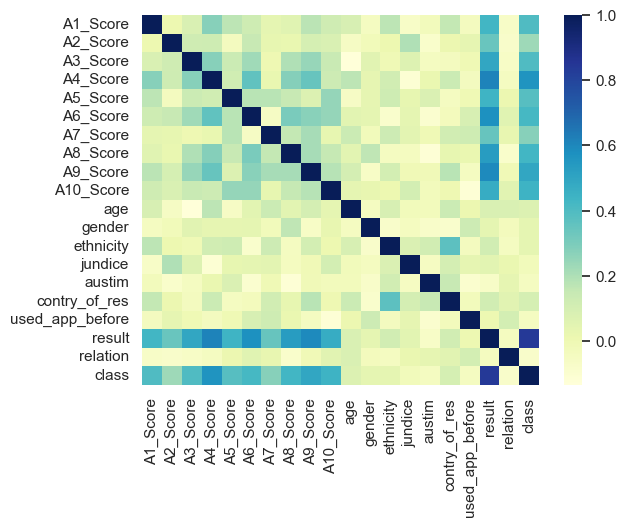

In [145]:
corr_matrix = dataset.corr()
sns.heatmap(corr_matrix, cmap="YlGnBu", fmt='g')
plt.show()

### Kreiranje train i test dataseta

In [146]:
y = dataset['class'].to_numpy()
x = dataset.drop(['class'], axis=1)

# x = (x - x.min()) / (x.max() - x.min())

scaler = StandardScaler()
x = scaler.fit_transform(x)

train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=0.2, stratify=y, shuffle=True)

### Klasifikacija

In [147]:
classifiers = {
    'RandomForest': RandomForestClassifier(),
    'SVM': SVC(),
    'KNN': KNeighborsClassifier(),
    'LogisticRegression': LogisticRegression(),
    'GradientBoosting': GradientBoostingClassifier()
}

param_grid = {
    'RandomForest': {'n_estimators': [50, 100, 200], 'max_depth': [None, 10, 20]},
    'SVM': {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']},
    'KNN': {'n_neighbors': [3, 5, 7]},
    'LogisticRegression': {'C': [0.1, 1, 10]},
    'GradientBoosting': {'n_estimators': [50, 100], 'learning_rate': [0.01, 0.1]}
}

best_models = {}
results = []

for name, clf in classifiers.items():
    print(f"Training {name}...")
    
    grid_search = GridSearchCV(clf, param_grid[name], cv=5, scoring='accuracy')
    grid_search.fit(train_x, train_y)
    best_models[name] = grid_search.best_estimator_

    y_pred = grid_search.best_estimator_.predict(test_x)

    accuracy = accuracy_score(test_y, y_pred)
    precision = precision_score(test_y, y_pred, average='weighted')
    recall = recall_score(test_y, y_pred, average='weighted')
    f1 = f1_score(test_y, y_pred, average='weighted')

    results.append({
        'Classifier': name,
        'Best Params': grid_search.best_params_,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1
    })

results_df = pd.DataFrame(results)

for name, model in best_models.items():
    print(f"\nClassification Report for {name}:")
    y_pred = model.predict(test_x)
    print(classification_report(test_y, y_pred))

Training RandomForest...
Training SVM...
Training KNN...
Training LogisticRegression...
Training GradientBoosting...

Classification Report for RandomForest:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        30
         1.0       1.00      1.00      1.00        28

    accuracy                           1.00        58
   macro avg       1.00      1.00      1.00        58
weighted avg       1.00      1.00      1.00        58


Classification Report for SVM:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        30
         1.0       1.00      1.00      1.00        28

    accuracy                           1.00        58
   macro avg       1.00      1.00      1.00        58
weighted avg       1.00      1.00      1.00        58


Classification Report for KNN:
              precision    recall  f1-score   support

         0.0       0.96      0.73      0.83        30
         1.0   

In [148]:
results_df

,Classifier,Best Params,Accuracy,Precision,Recall,F1 Score
0,RandomForest,"{'max_depth': None, 'n_estimators': 50}",1.00,1.00,1.00,1.00
1,SVM,"{'C': 1, 'kernel': 'linear'}",1.00,1.00,1.00,1.00
2,KNN,{'n_neighbors': 5},0.84,0.87,0.84,0.84
3,LogisticRegression,{'C': 10},1.00,1.00,1.00,1.00
4,GradientBoosting,"{'learning_rate': 0.01, 'n_estimators': 50}",1.00,1.00,1.00,1.00


### Redukcija dimenzionalnosti

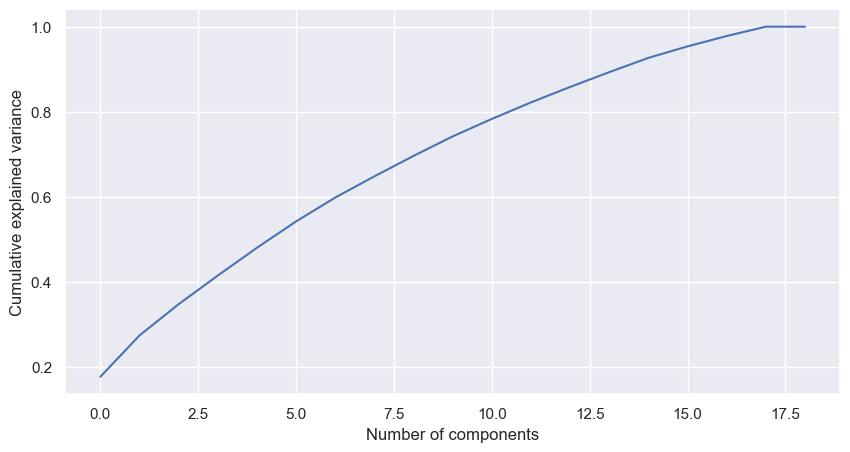

In [149]:
pca = PCA()
pca.fit(train_x)
data_pca = pca.transform(train_x)

plt.figure(figsize=(10, 5))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.show()

In [150]:
pca_9 = PCA(n_components=0.9)
x_train_pca = pca_9.fit_transform(train_x)
x_test_pca = pca_9.transform(test_x)

In [151]:
classifiers = {
    'RandomForest': RandomForestClassifier(),
    'SVM': SVC(),
    'KNN': KNeighborsClassifier(),
    'LogisticRegression': LogisticRegression(),
    'GradientBoosting': GradientBoostingClassifier()
}

param_grid = {
    'RandomForest': {'n_estimators': [50, 100, 200], 'max_depth': [None, 10, 20]},
    'SVM': {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']},
    'KNN': {'n_neighbors': [3, 5, 7]},
    'LogisticRegression': {'C': [0.1, 1, 10]},
    'GradientBoosting': {'n_estimators': [50, 100], 'learning_rate': [0.01, 0.1]}
}

best_models = {}
results = []

for name, clf in classifiers.items():
    print(f"Training {name}...")
    
    grid_search = GridSearchCV(clf, param_grid[name], cv=5, scoring='accuracy')
    grid_search.fit(x_train_pca, train_y)
    best_models[name] = grid_search.best_estimator_

    y_pred = grid_search.best_estimator_.predict(x_test_pca)

    accuracy = accuracy_score(test_y, y_pred)
    precision = precision_score(test_y, y_pred, average='weighted')
    recall = recall_score(test_y, y_pred, average='weighted')
    f1 = f1_score(test_y, y_pred, average='weighted')

    results.append({
        'Classifier': name,
        'Best Params': grid_search.best_params_,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1
    })

results_df_pca = pd.DataFrame(results)

for name, model in best_models.items():
    print(f"\nClassification Report for {name}:")
    y_pred = model.predict(x_test_pca)
    print(classification_report(test_y, y_pred))

Training RandomForest...
Training SVM...
Training KNN...
Training LogisticRegression...
Training GradientBoosting...

Classification Report for RandomForest:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        30
         1.0       1.00      1.00      1.00        28

    accuracy                           1.00        58
   macro avg       1.00      1.00      1.00        58
weighted avg       1.00      1.00      1.00        58


Classification Report for SVM:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        30
         1.0       1.00      1.00      1.00        28

    accuracy                           1.00        58
   macro avg       1.00      1.00      1.00        58
weighted avg       1.00      1.00      1.00        58


Classification Report for KNN:
              precision    recall  f1-score   support

         0.0       0.96      0.77      0.85        30
         1.0   

In [152]:
display(results_df, results_df_pca)

,Classifier,Best Params,Accuracy,Precision,Recall,F1 Score
0,RandomForest,"{'max_depth': None, 'n_estimators': 50}",1.00,1.00,1.00,1.00
1,SVM,"{'C': 1, 'kernel': 'linear'}",1.00,1.00,1.00,1.00
2,KNN,{'n_neighbors': 5},0.84,0.87,0.84,0.84
3,LogisticRegression,{'C': 10},1.00,1.00,1.00,1.00
4,GradientBoosting,"{'learning_rate': 0.01, 'n_estimators': 50}",1.00,1.00,1.00,1.00


,Classifier,Best Params,Accuracy,Precision,Recall,F1 Score
0,RandomForest,"{'max_depth': None, 'n_estimators': 50}",1.00,1.00,1.00,1.00
1,SVM,"{'C': 1, 'kernel': 'linear'}",1.00,1.00,1.00,1.00
2,KNN,{'n_neighbors': 7},0.86,0.88,0.86,0.86
3,LogisticRegression,{'C': 10},1.00,1.00,1.00,1.00
4,GradientBoosting,"{'learning_rate': 0.01, 'n_estimators': 50}",0.98,0.98,0.98,0.98


In [154]:
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

best_classifiers = {
    'RandomForest': RandomForestClassifier(max_depth=None, n_estimators=50),
    'SVM': SVC(C=1, kernel='linear'),
    'KNN': KNeighborsClassifier(n_neighbors=5),
    'LogisticRegression': LogisticRegression(C=10),
    'GradientBoosting': GradientBoostingClassifier(learning_rate=0.01, n_estimators=50)
}

results = []

for name, clf in best_classifiers.items():
    print(f"Evaluating {name} with cross-validation...")
    
    accuracies = cross_val_score(clf, x, y, cv=kf, scoring='accuracy')
    precisions = cross_val_score(clf, x, y, cv=kf, scoring='precision_weighted')
    recalls = cross_val_score(clf, x, y, cv=kf, scoring='recall_weighted')
    f1s = cross_val_score(clf, x, y, cv=kf, scoring='f1_weighted')
    
    results.append({
        'Classifier': name,
        'Accuracy (Mean CV)': accuracies.mean(),
        'Accuracy (Std CV)': accuracies.std(),
        'Precision (Mean CV)': precisions.mean(),
        'Recall (Mean CV)': recalls.mean(),
        'F1 Score (Mean CV)': f1s.mean()
    })

results_df_cv = pd.DataFrame(results)

results_df_cv

Evaluating RandomForest with cross-validation...
Evaluating SVM with cross-validation...
Evaluating KNN with cross-validation...
Evaluating LogisticRegression with cross-validation...
Evaluating GradientBoosting with cross-validation...


,Classifier,Accuracy (Mean CV),Accuracy (Std CV),Precision (Mean CV),Recall (Mean CV),F1 Score (Mean CV)
0,RandomForest,1.00,0.00,1.00,1.00,1.00
1,SVM,1.00,0.00,1.00,1.00,1.00
2,KNN,0.91,0.02,0.91,0.91,0.91
3,LogisticRegression,1.00,0.00,1.00,1.00,1.00
4,GradientBoosting,1.00,0.00,1.00,1.00,1.00
